In [1]:
import os
import sys

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
!pip install pytorch-ood

In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torchvision.transforms as tvt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100, SVHN, Places365
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import random

from pytorch_ood.dataset.img import (
    LSUNCrop,
    LSUNResize,
    Textures,
    TinyImageNetCrop,
    TinyImageNetResize,
)
from pytorch_ood.detector import (
    ODIN,
    EnergyBased,
    Entropy,
    KLMatching,
    Mahalanobis,
    MaxLogit,
    MaxSoftmax,
    ViM,
    RMD,
    DICE,
    SHE,
)
from pytorch_ood.model import WideResNet
from pytorch_ood.utils import OODMetrics, ToRGB, ToUnknown

torch.manual_seed(1234)

mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

trans = tvt.Compose([
    tvt.Resize(size=(32, 32)),
    ToRGB(),
    tvt.ToTensor(),
    tvt.Normalize(std=std, mean=mean)
])

In [3]:
def calculate(test_loader, detector, name):
    metrics = OODMetrics() # Evaluate Detectors

    print("Total count:", len(test_loader))
    cnt = 0
    for x, y in test_loader:
        metrics.update(detector(x.cuda()), y)
        cnt += 1
        if (cnt + 1) % 50 == 0:
            print(f"[{cnt}/{len(test_loader)}]")

    r = metrics.compute()
    print()
    print(name)
    print(r)
    return r

In [4]:
CIFAR_test_dataset = CIFAR100(root="data", train=False, download=True, transform=trans)
CIFAR_test_loader = DataLoader(CIFAR_test_dataset, batch_size=128, num_workers=20)

def test(model):
    model.eval()
    benign_loss = 0
    adv_loss = 0
    benign_correct = 0
    adv_correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(CIFAR_test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            total += targets.size(0)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            benign_loss += loss.item()

            _, predicted = outputs.max(1)
            benign_correct += predicted.eq(targets).sum().item()

            if batch_idx % 10 == 0:
                print('\nCurrent batch:', str(batch_idx))
                print('Current benign test accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
                print('Current benign test loss:', loss.item())

    print('Total benign test accuarcy:', 100. * benign_correct / total)
    print('Total benign test loss:', benign_loss)

Files already downloaded and verified


In [5]:
def evaluate(model):
    dataset_in_test = CIFAR100(root="data", train=False, download=True, transform=trans)
    loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

    detector = MaxSoftmax(model)
    detector.fit(loader_in_train, device="cuda")

    result = []
    dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

    dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
    test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
    result.append(calculate(test_loader, detector, dataset_names[0]))

    dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
    test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
    result.append(calculate(test_loader, detector, dataset_names[1]))

    dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
    test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
    result.append(calculate(test_loader, detector, dataset_names[2]))

    dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
    test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
    result.append(calculate(test_loader, detector, dataset_names[3]))

    dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
    test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
    result.append(calculate(test_loader, detector, dataset_names[4]))

    dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
    test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
    result.append(calculate(test_loader, detector, dataset_names[5]))

    dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown()) # , download=True)
    test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
    result.append(calculate(test_loader, detector, dataset_names[6]))

    mean_AUROC = 0
    mean_FPR = 0
    for r in result:
        mean_AUROC += r["AUROC"] / len(result)
        mean_FPR += r["FPR95TPR"] / len(result)
    print("AUROC:", mean_AUROC)
    print("FPR:", mean_FPR)

### Multiple Input Mixup for Out-of-Distribution Detection (MIM)

In [6]:
def MixUp(inputs):
    batch_size = inputs.size(0)
    index = [torch.randperm(batch_size) for _ in range(mix_size)]
    
    mixed_input = torch.zeros_like(inputs)
    for i in range(batch_size):
        for j in range(mix_size):
            mixed_input[i] += inputs[index[j][i], :] / mix_size
            
    return mixed_input

def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)    # The inverse of normalization formula
    return tensor

In [7]:
new_trans = tvt.Compose([
    tvt.Resize(size=(32, 32)),
    ToRGB(),
    tvt.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.3, hue=0.3),  
    tvt.RandomAffine((-90,90), translate=(0.2, 0.2)),
    tvt.ToTensor(),
    tvt.Normalize(std=std, mean=mean)
])

Files already downloaded and verified
Files already downloaded and verified


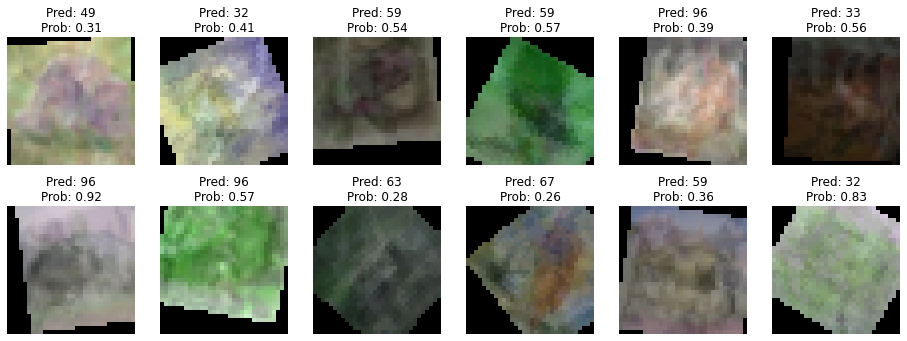

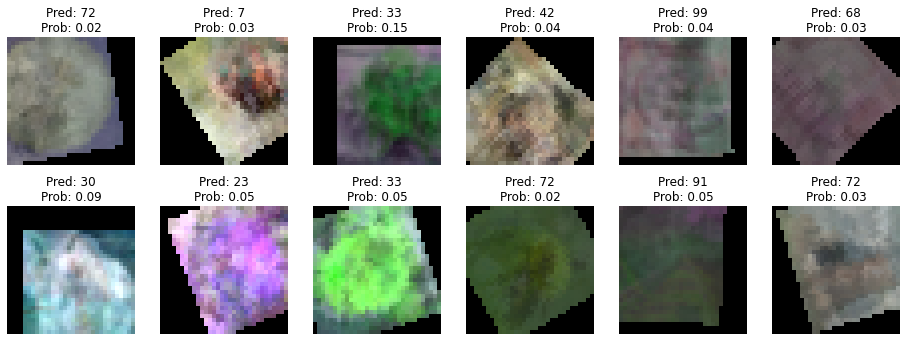


Current batch: 30
Current adversarial train accuracy: 0.9453125
Current adversarial train loss: 0.2779466211795807
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8633325099945068, 'AUPR-IN': 0.7910612225532532, 'AUPR-OUT': 0.9097109436988831, 'FPR95TPR': 0.5544000267982483}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9676491618156433, 'AUPR-IN': 0.9646857380867004, 'AUPR-OUT': 0.9695938229560852, 'FPR95TPR': 0.16179999709129333}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9176162481307983, 'AUPR-IN': 0.8917710185050964, 'AUPR-OUT': 0.9298222661018372, 'FPR95TPR': 0.31310001015663147}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9663233757019043, 'AUPR-IN': 0.9617140293121338, 'AUPR-OUT': 0.9689413905143738, 'FPR95TPR': 0.15209999680519104}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9172230958938599, 'AUPR-IN': 0.897670447826385

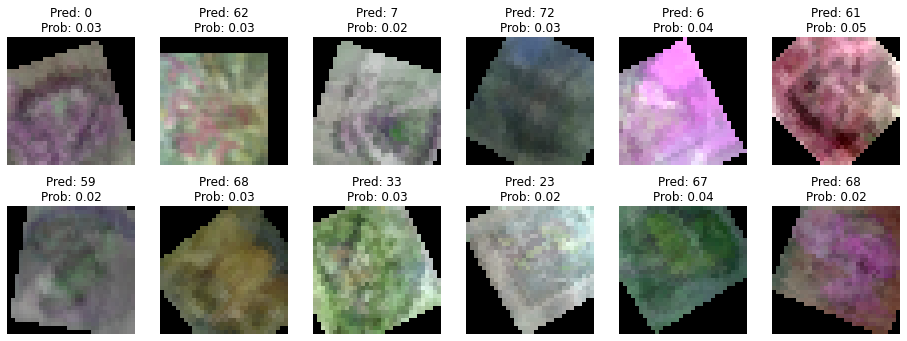


Current batch: 60
Current adversarial train accuracy: 0.9609375
Current adversarial train loss: 0.25001445412635803
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8677679300308228, 'AUPR-IN': 0.8094980716705322, 'AUPR-OUT': 0.9133316874504089, 'FPR95TPR': 0.5404999852180481}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9486754536628723, 'AUPR-IN': 0.9497440457344055, 'AUPR-OUT': 0.9498171806335449, 'FPR95TPR': 0.2851000130176544}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.8996566534042358, 'AUPR-IN': 0.872143030166626, 'AUPR-OUT': 0.9150539636611938, 'FPR95TPR': 0.3544999957084656}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9611829519271851, 'AUPR-IN': 0.9595363140106201, 'AUPR-OUT': 0.9636043310165405, 'FPR95TPR': 0.19499999284744263}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9035301208496094, 'AUPR-IN': 0.884255051612854, 

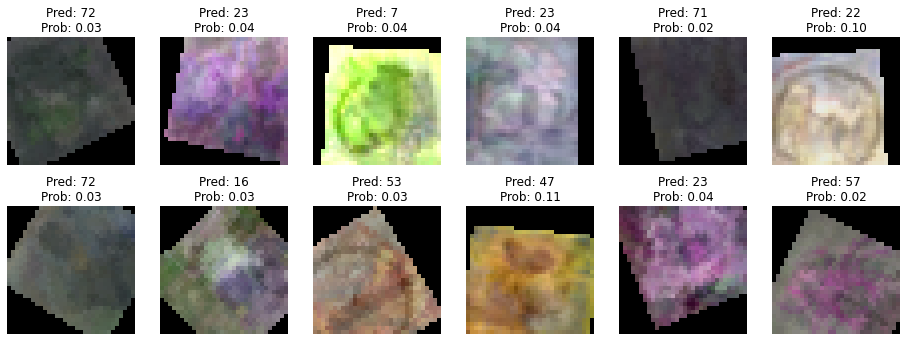


Current batch: 90
Current adversarial train accuracy: 0.96875
Current adversarial train loss: 0.18476168811321259
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8691778182983398, 'AUPR-IN': 0.8126800060272217, 'AUPR-OUT': 0.9141701459884644, 'FPR95TPR': 0.5388000011444092}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9505752921104431, 'AUPR-IN': 0.9517636299133301, 'AUPR-OUT': 0.9518221616744995, 'FPR95TPR': 0.28290000557899475}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9016590118408203, 'AUPR-IN': 0.8758388757705688, 'AUPR-OUT': 0.9163753390312195, 'FPR95TPR': 0.3555999994277954}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9627714157104492, 'AUPR-IN': 0.9615911245346069, 'AUPR-OUT': 0.9648597836494446, 'FPR95TPR': 0.18970000743865967}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9052932858467102, 'AUPR-IN': 0.887497067451477, 

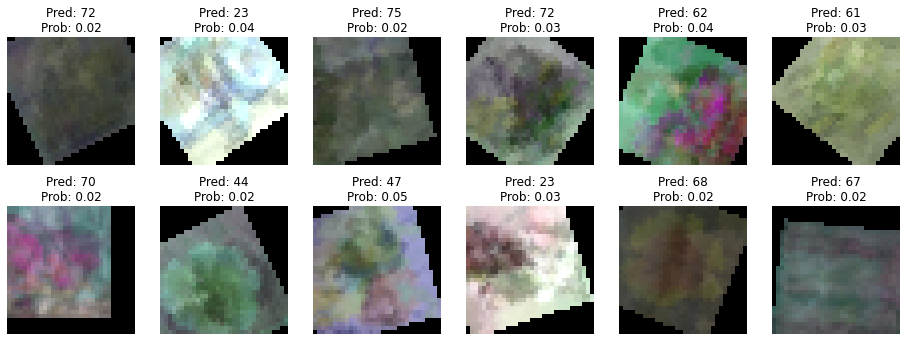


Current batch: 120
Current adversarial train accuracy: 0.96875
Current adversarial train loss: 0.17881134152412415
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8728442788124084, 'AUPR-IN': 0.8190874457359314, 'AUPR-OUT': 0.9160478711128235, 'FPR95TPR': 0.532800018787384}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9548571109771729, 'AUPR-IN': 0.955492377281189, 'AUPR-OUT': 0.9561517238616943, 'FPR95TPR': 0.2637999951839447}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9013198614120483, 'AUPR-IN': 0.8749021887779236, 'AUPR-OUT': 0.9160623550415039, 'FPR95TPR': 0.35339999198913574}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9645003080368042, 'AUPR-IN': 0.9632375240325928, 'AUPR-OUT': 0.9664222002029419, 'FPR95TPR': 0.18060000240802765}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.905066192150116, 'AUPR-IN': 0.8863705396652222, '

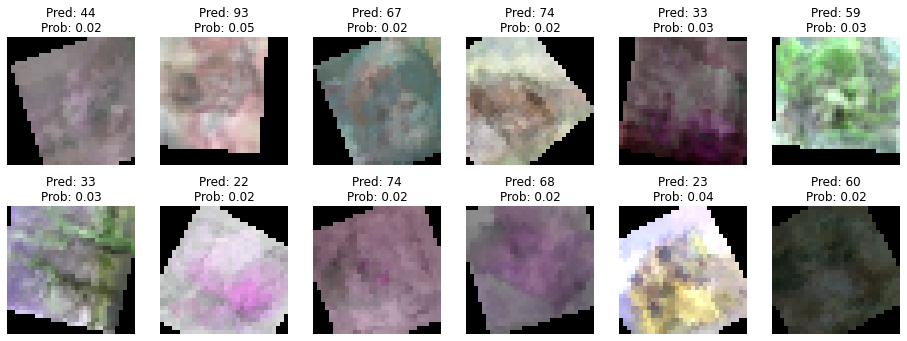


Current batch: 150
Current adversarial train accuracy: 1.0
Current adversarial train loss: 0.09016527980566025
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8727703094482422, 'AUPR-IN': 0.8202962875366211, 'AUPR-OUT': 0.9158450365066528, 'FPR95TPR': 0.5351999998092651}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9554821848869324, 'AUPR-IN': 0.956551194190979, 'AUPR-OUT': 0.9566617608070374, 'FPR95TPR': 0.26260000467300415}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9015642404556274, 'AUPR-IN': 0.8774288892745972, 'AUPR-OUT': 0.915884792804718, 'FPR95TPR': 0.3571000099182129}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.96486496925354, 'AUPR-IN': 0.9640438556671143, 'AUPR-OUT': 0.9665889739990234, 'FPR95TPR': 0.18539999425411224}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9037942290306091, 'AUPR-IN': 0.8868532180786133, 'AUPR-

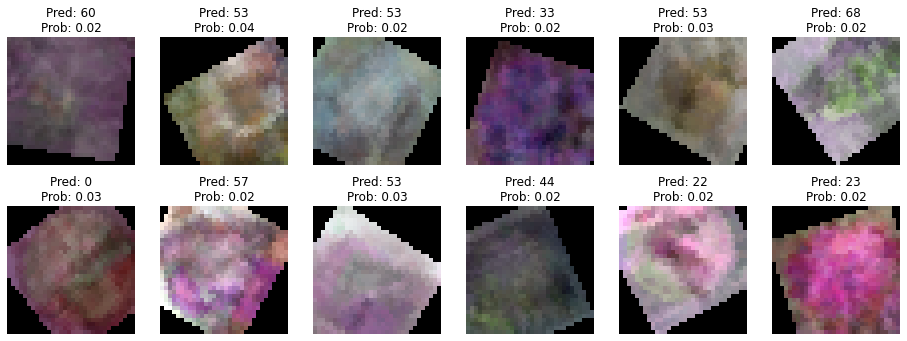


Current batch: 180
Current adversarial train accuracy: 0.9765625
Current adversarial train loss: 0.18514740467071533
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8722489476203918, 'AUPR-IN': 0.8206657767295837, 'AUPR-OUT': 0.914802610874176, 'FPR95TPR': 0.5396999716758728}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9564119577407837, 'AUPR-IN': 0.9572165608406067, 'AUPR-OUT': 0.957661509513855, 'FPR95TPR': 0.2556000053882599}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9025915861129761, 'AUPR-IN': 0.8779821991920471, 'AUPR-OUT': 0.9167470335960388, 'FPR95TPR': 0.3522000014781952}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9651141166687012, 'AUPR-IN': 0.9641697406768799, 'AUPR-OUT': 0.9668195247650146, 'FPR95TPR': 0.18479999899864197}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9045636057853699, 'AUPR-IN': 0.887198269367218, 

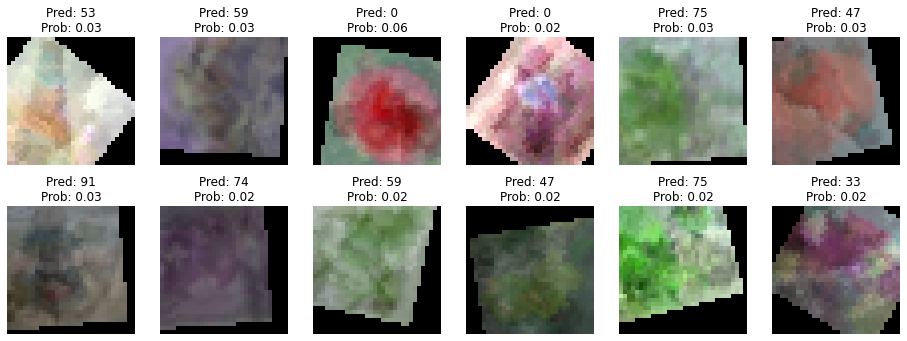


Current batch: 210
Current adversarial train accuracy: 1.0
Current adversarial train loss: 0.05510193482041359
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8739404678344727, 'AUPR-IN': 0.8241878151893616, 'AUPR-OUT': 0.9157788753509521, 'FPR95TPR': 0.5385000109672546}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9572910666465759, 'AUPR-IN': 0.9580492377281189, 'AUPR-OUT': 0.958484411239624, 'FPR95TPR': 0.25060001015663147}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9002164006233215, 'AUPR-IN': 0.8758554458618164, 'AUPR-OUT': 0.9145361185073853, 'FPR95TPR': 0.3580000102519989}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9654058814048767, 'AUPR-IN': 0.9644685387611389, 'AUPR-OUT': 0.967023491859436, 'FPR95TPR': 0.18549999594688416}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.902452826499939, 'AUPR-IN': 0.885127067565918, 'AUPR-

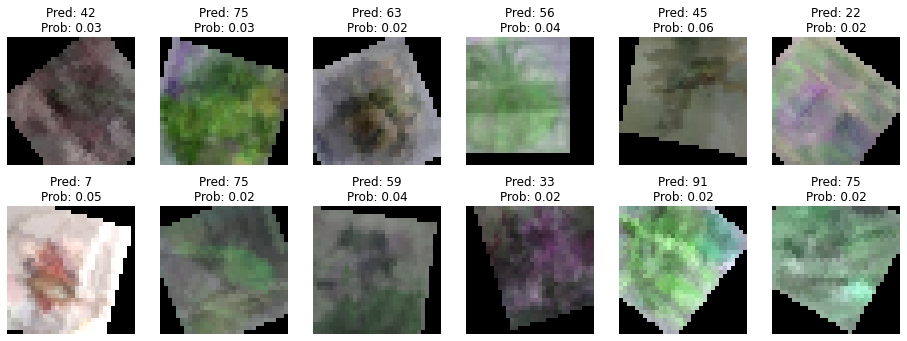


Current batch: 240
Current adversarial train accuracy: 0.96875
Current adversarial train loss: 0.13175059854984283
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8728957176208496, 'AUPR-IN': 0.8232129812240601, 'AUPR-OUT': 0.9150682687759399, 'FPR95TPR': 0.5376999974250793}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9586154222488403, 'AUPR-IN': 0.9594334363937378, 'AUPR-OUT': 0.9597862958908081, 'FPR95TPR': 0.24609999358654022}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.8983667492866516, 'AUPR-IN': 0.8755410313606262, 'AUPR-OUT': 0.9126201868057251, 'FPR95TPR': 0.3635999858379364}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9655293226242065, 'AUPR-IN': 0.9648404121398926, 'AUPR-OUT': 0.9670310020446777, 'FPR95TPR': 0.1867000013589859}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9003209471702576, 'AUPR-IN': 0.8839974403381348,

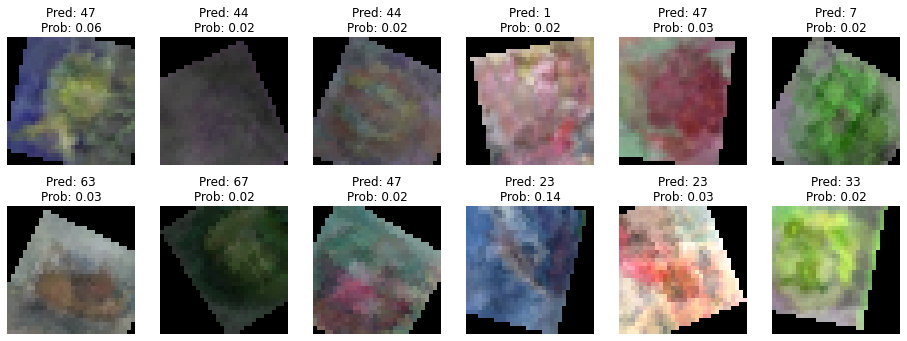


Current batch: 270
Current adversarial train accuracy: 0.9921875
Current adversarial train loss: 0.07009967416524887
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8708480000495911, 'AUPR-IN': 0.8209975957870483, 'AUPR-OUT': 0.9133270978927612, 'FPR95TPR': 0.5449000000953674}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9588419198989868, 'AUPR-IN': 0.9596260786056519, 'AUPR-OUT': 0.9600374102592468, 'FPR95TPR': 0.24699999392032623}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.8974950313568115, 'AUPR-IN': 0.8747007250785828, 'AUPR-OUT': 0.9118435978889465, 'FPR95TPR': 0.36880001425743103}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9651345014572144, 'AUPR-IN': 0.9644725322723389, 'AUPR-OUT': 0.9666304588317871, 'FPR95TPR': 0.18930000066757202}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.8986605405807495, 'AUPR-IN': 0.8822792172431

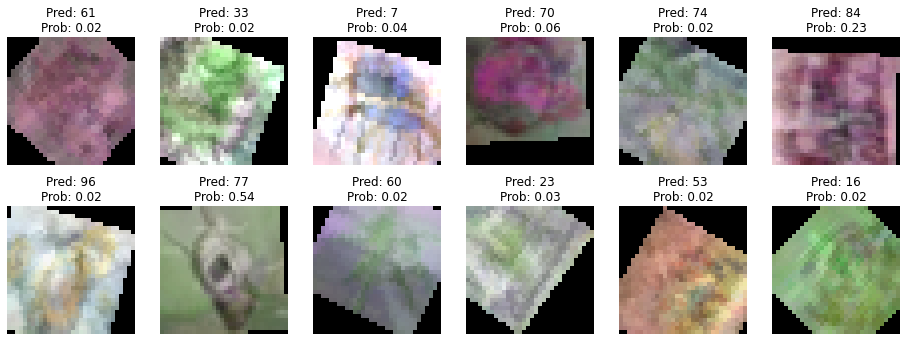


Current batch: 300
Current adversarial train accuracy: 1.0
Current adversarial train loss: 0.08249109238386154
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8693491816520691, 'AUPR-IN': 0.8197256326675415, 'AUPR-OUT': 0.9119656085968018, 'FPR95TPR': 0.5479000210762024}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9598901271820068, 'AUPR-IN': 0.9606985449790955, 'AUPR-OUT': 0.9610686302185059, 'FPR95TPR': 0.2379000037908554}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.8923191428184509, 'AUPR-IN': 0.8702049255371094, 'AUPR-OUT': 0.9072349071502686, 'FPR95TPR': 0.3799999952316284}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9648500084877014, 'AUPR-IN': 0.9644038081169128, 'AUPR-OUT': 0.9662566781044006, 'FPR95TPR': 0.19249999523162842}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.8935011625289917, 'AUPR-IN': 0.8777216076850891, 'AU

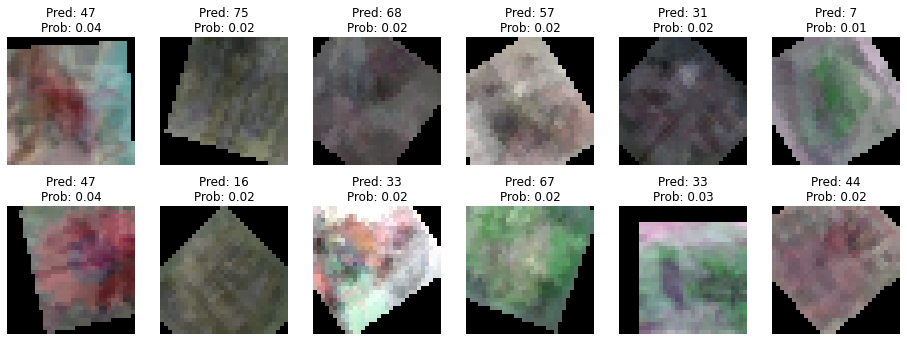


Current batch: 330
Current adversarial train accuracy: 0.9921875
Current adversarial train loss: 0.10718371719121933
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8710306882858276, 'AUPR-IN': 0.8217425346374512, 'AUPR-OUT': 0.9132301807403564, 'FPR95TPR': 0.5410000085830688}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9617723226547241, 'AUPR-IN': 0.962306022644043, 'AUPR-OUT': 0.9629643559455872, 'FPR95TPR': 0.2257000058889389}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.8957159519195557, 'AUPR-IN': 0.8741477727890015, 'AUPR-OUT': 0.9100603461265564, 'FPR95TPR': 0.374099999666214}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9667980074882507, 'AUPR-IN': 0.9662684798240662, 'AUPR-OUT': 0.9681011438369751, 'FPR95TPR': 0.17829999327659607}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.8970420360565186, 'AUPR-IN': 0.88163161277771, '

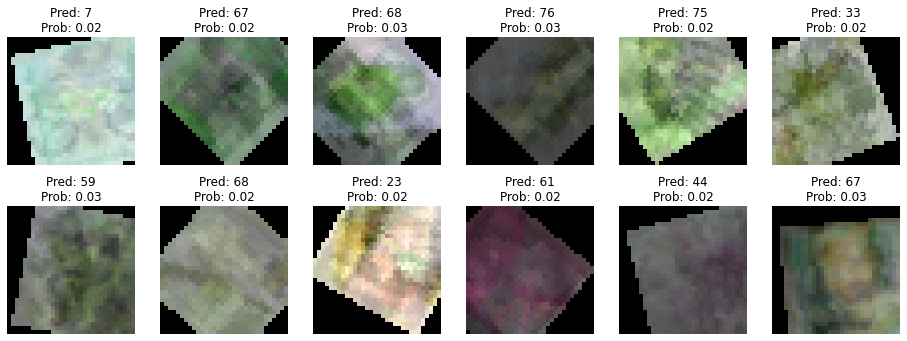


Current batch: 360
Current adversarial train accuracy: 0.9921875
Current adversarial train loss: 0.054966334253549576
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8686846494674683, 'AUPR-IN': 0.8187556266784668, 'AUPR-OUT': 0.9115463495254517, 'FPR95TPR': 0.5449000000953674}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9606647491455078, 'AUPR-IN': 0.9613859057426453, 'AUPR-OUT': 0.9618817567825317, 'FPR95TPR': 0.23229999840259552}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.8895174264907837, 'AUPR-IN': 0.8686627149581909, 'AUPR-OUT': 0.9045909643173218, 'FPR95TPR': 0.388700008392334}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.964539647102356, 'AUPR-IN': 0.9642598628997803, 'AUPR-OUT': 0.9658690094947815, 'FPR95TPR': 0.19750000536441803}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.8904769420623779, 'AUPR-IN': 0.875195086002349

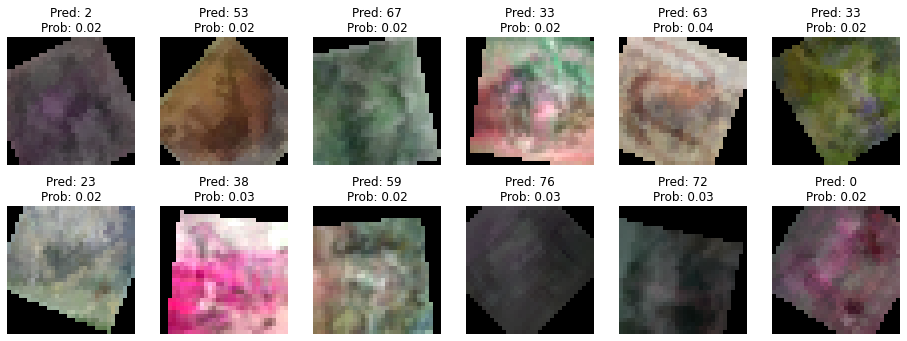


Current batch: 390
Current adversarial train accuracy: 0.9625
Current adversarial train loss: 0.1419234573841095
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8693824410438538, 'AUPR-IN': 0.8198485374450684, 'AUPR-OUT': 0.9120234251022339, 'FPR95TPR': 0.5421000123023987}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9610843658447266, 'AUPR-IN': 0.9616115689277649, 'AUPR-OUT': 0.96234530210495, 'FPR95TPR': 0.23199999332427979}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.8942049145698547, 'AUPR-IN': 0.8732432723045349, 'AUPR-OUT': 0.908726692199707, 'FPR95TPR': 0.37779998779296875}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9658834338188171, 'AUPR-IN': 0.9654587507247925, 'AUPR-OUT': 0.9671955108642578, 'FPR95TPR': 0.186599999666214}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.8953256011009216, 'AUPR-IN': 0.8804721236228943, 'AUP

In [8]:
model = WideResNet(num_classes=100, pretrained="cifar100-pt").cuda().eval()
mix_size = 5

train_loss = 0
correct = 0
total = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

CIFAR_train_dataset = CIFAR100(root="data", train=True, download=True, transform=trans)
CIFAR_train_loader = DataLoader(CIFAR_train_dataset, batch_size=128, num_workers=20)

CIFAR_train_dataset_mix = CIFAR100(root="data", train=True, download=True, transform=new_trans)
CIFAR_train_loader_mix = DataLoader(CIFAR_train_dataset, batch_size=128, num_workers=20)

original_confidences = []
mixed_confidences = []
num_epoch = 1

for epoch in range(num_epoch):
    log_step = 30
    for batch_idx, ((inputs, targets), (inputs_mix, targets_mix)) in enumerate(zip(CIFAR_train_loader, CIFAR_train_loader_mix)):

        inputs, targets = inputs.cuda(), targets.cuda()
        inputs_mix, targets_mix = inputs_mix.cuda(), targets_mix.cuda()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        train_loss += loss.item()
        _, predicted = outputs.max(1)

        original_prob = torch.softmax(outputs, dim=1).max(1)[0].detach().cpu().numpy()
        original_confidences.append(original_prob)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        mixed_input = MixUp(inputs_mix)
        for i in range(inputs.size(0)):
            mixed_input_pil = to_pil_image(unnormalize(mixed_input[i], mean, std))
            mixed_input[i] = new_trans(mixed_input_pil)

        mixed_outputs = model(mixed_input)
        _, mixed_preds = torch.max(mixed_outputs.data, 1)

        mixed_prob = torch.max(torch.softmax(mixed_outputs[0], dim=0)).item()
        mixed_confidences.append(mixed_prob)

        if batch_idx % log_step == 0:
            plt.figure(figsize=(16, 5.7))
            for i in range(12):
                img = mixed_input[i].cpu()
                img = unnormalize(img, mean, std)
                img = img.numpy().transpose((1, 2, 0))
                predicted_label = mixed_preds[i].item()  
                predicted_prob = torch.max(torch.softmax(mixed_outputs[i], dim=0)).item()  
                plt.subplot(2, 6, i+1)
                plt.imshow(img)
                plt.title(f"Pred: {predicted_label}\nProb: {predicted_prob:.2f}")
                plt.axis('off')
            plt.show()

        batch_size = inputs.size(0)
        uniform_labels = torch.ones((batch_size, 100), dtype=torch.int64).cuda() / 100
        uniform_loss = criterion(mixed_outputs, uniform_labels).cuda()

        total_loss = loss + uniform_loss
        total_loss.backward()

        optimizer.step()

        if batch_idx != 0 and batch_idx % 30 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current adversarial train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current adversarial train loss:', loss.item())
            evaluate(model)
            test(model)
evaluate(model)

### Other Methods

#### MSP

In [9]:
model = WideResNet(num_classes=100, pretrained="cifar100-pt").cuda().eval()

dataset_in_test = CIFAR100(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = MaxSoftmax(model)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.7356701493263245, 'AUPR-IN': 0.5750707983970642, 'AUPR-OUT': 0.8316090106964111, 'FPR95TPR': 0.7142999768257141}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.8558782339096069, 'AUPR-IN': 0.8435631394386292, 'AUPR-OUT': 0.8740410804748535, 'FPR95TPR': 0.47130000591278076}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.7537872195243835, 'AUPR-IN': 0.7116444706916809, 'AUPR-OUT': 0.7850341200828552, 'FPR95TPR': 0.6335999965667725}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.8632166385650635, 'AUPR-IN': 0.8480733633041382, 'AUPR-OUT': 0.8823278546333313, 'FPR95TPR': 0.4334999918937683}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.7464348077774048, 'AUPR-IN': 0.709132194519043, 'AUPR-OUT': 0.7729100584983826, 'FPR95TPR': 0.6552000045776367}
Using downloaded and verified file: data/test_32x32.

#### ODIN

In [10]:
model = WideResNet(num_classes=100, pretrained="cifar100-pt").cuda().eval()

dataset_in_test = CIFAR100(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = ODIN(model, eps=0.002)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.7262358665466309, 'AUPR-IN': 0.5728436708450317, 'AUPR-OUT': 0.8262792825698853, 'FPR95TPR': 0.7236999869346619}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.8569039702415466, 'AUPR-IN': 0.8468574285507202, 'AUPR-OUT': 0.875266969203949, 'FPR95TPR': 0.460999995470047}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.786485493183136, 'AUPR-IN': 0.7651017904281616, 'AUPR-OUT': 0.8077059984207153, 'FPR95TPR': 0.6154999732971191}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.8736329078674316, 'AUPR-IN': 0.8623830080032349, 'AUPR-OUT': 0.889984130859375, 'FPR95TPR': 0.42250001430511475}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.7790060639381409, 'AUPR-IN': 0.7624589800834656, 'AUPR-OUT': 0.795867919921875, 'FPR95TPR': 0.6291000247001648}
Using downloaded and verified file: data/test_32x32.mat


#### Mahalanobis

In [11]:
model = WideResNet(num_classes=100, pretrained="cifar100-pt").cuda().eval()

dataset_in_test = CIFAR100(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = Mahalanobis(model.features)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8993708491325378, 'AUPR-IN': 0.8529452085494995, 'AUPR-OUT': 0.9366945028305054, 'FPR95TPR': 0.4551999866962433}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.5203647613525391, 'AUPR-IN': 0.46743983030319214, 'AUPR-OUT': 0.5986385345458984, 'FPR95TPR': 0.8277999758720398}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9443700313568115, 'AUPR-IN': 0.9404587745666504, 'AUPR-OUT': 0.9487005472183228, 'FPR95TPR': 0.2529999911785126}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.5595659613609314, 'AUPR-IN': 0.49223220348358154, 'AUPR-OUT': 0.6488624811172485, 'FPR95TPR': 0.7591999769210815}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9330646395683289, 'AUPR-IN': 0.9321653246879578, 'AUPR-OUT': 0.9363183975219727, 'FPR95TPR': 0.3181999921798706}
Using downloaded and verified file: data/test_32x3

#### Entropy

In [12]:
model = WideResNet(num_classes=100, pretrained="cifar100-pt").cuda().eval()

dataset_in_test = CIFAR100(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = Entropy(model.features)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.5466389060020447, 'AUPR-IN': 0.39550551772117615, 'AUPR-OUT': 0.6728155612945557, 'FPR95TPR': 0.9347000122070312}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.8961294293403625, 'AUPR-IN': 0.8989497423171997, 'AUPR-OUT': 0.8961869478225708, 'FPR95TPR': 0.4560999870300293}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.6603476405143738, 'AUPR-IN': 0.5927212238311768, 'AUPR-OUT': 0.7000846862792969, 'FPR95TPR': 0.7527999877929688}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9191513061523438, 'AUPR-IN': 0.920604944229126, 'AUPR-OUT': 0.9180685877799988, 'FPR95TPR': 0.37139999866485596}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.6394122838973999, 'AUPR-IN': 0.5853877067565918, 'AUPR-OUT': 0.6714671850204468, 'FPR95TPR': 0.7907000184059143}
Using downloaded and verified file: data/test_32x32

#### Energy

In [13]:
model = WideResNet(num_classes=100, pretrained="cifar100-pt").cuda().eval()

dataset_in_test = CIFAR100(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = EnergyBased(model.features)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.5353693962097168, 'AUPR-IN': 0.39706969261169434, 'AUPR-OUT': 0.6611156463623047, 'FPR95TPR': 0.941100001335144}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9691354036331177, 'AUPR-IN': 0.9712628722190857, 'AUPR-OUT': 0.9676560759544373, 'FPR95TPR': 0.17339999973773956}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.564987301826477, 'AUPR-IN': 0.51377934217453, 'AUPR-OUT': 0.6136684417724609, 'FPR95TPR': 0.8355000019073486}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9592421054840088, 'AUPR-IN': 0.9581956267356873, 'AUPR-OUT': 0.9593265652656555, 'FPR95TPR': 0.1979999989271164}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.5618534088134766, 'AUPR-IN': 0.5190807580947876, 'AUPR-OUT': 0.5984709858894348, 'FPR95TPR': 0.8536999821662903}
Using downloaded and verified file: data/test_32x32.ma

#### MaxLogit

In [14]:
model = WideResNet(num_classes=100, pretrained="cifar100-pt").cuda().eval()

dataset_in_test = CIFAR100(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = MaxLogit(model)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.7637693881988525, 'AUPR-IN': 0.6164882779121399, 'AUPR-OUT': 0.8514449596405029, 'FPR95TPR': 0.7103999853134155}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9514685273170471, 'AUPR-IN': 0.9468564987182617, 'AUPR-OUT': 0.9569815993309021, 'FPR95TPR': 0.21719999611377716}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.7932236194610596, 'AUPR-IN': 0.7519266605377197, 'AUPR-OUT': 0.8102834224700928, 'FPR95TPR': 0.6157000064849854}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9467613697052002, 'AUPR-IN': 0.9401830434799194, 'AUPR-OUT': 0.953149139881134, 'FPR95TPR': 0.22439999878406525}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.7769277691841125, 'AUPR-IN': 0.7421035766601562, 'AUPR-OUT': 0.7908072471618652, 'FPR95TPR': 0.6575999855995178}
Using downloaded and verified file: data/test_32x32

#### KL-Matching

In [15]:
model = WideResNet(num_classes=100, pretrained="cifar100-pt").cuda().eval()

dataset_in_test = CIFAR100(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = KLMatching(model)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.7189435958862305, 'AUPR-IN': 0.631015956401825, 'AUPR-OUT': 0.7845979928970337, 'FPR95TPR': 0.8518000245094299}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.7772538661956787, 'AUPR-IN': 0.8041593432426453, 'AUPR-OUT': 0.6868449449539185, 'FPR95TPR': 0.945900022983551}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.7814863920211792, 'AUPR-IN': 0.7876704335212708, 'AUPR-OUT': 0.7785518169403076, 'FPR95TPR': 0.6504999995231628}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.8209723830223083, 'AUPR-IN': 0.8180628418922424, 'AUPR-OUT': 0.7937166094779968, 'FPR95TPR': 0.7091000080108643}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.7635491490364075, 'AUPR-IN': 0.7662689089775085, 'AUPR-OUT': 0.7671324610710144, 'FPR95TPR': 0.6531999707221985}
Using downloaded and verified file: data/test_32x32.ma

#### DICE

In [16]:
model = WideResNet(num_classes=100, pretrained="cifar100-pt").cuda().eval()

dataset_in_test = CIFAR100(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = DICE(model=model.features, w=model.fc.weight, b=model.fc.bias, p=0.65)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.7649083137512207, 'AUPR-IN': 0.6213765144348145, 'AUPR-OUT': 0.8519936203956604, 'FPR95TPR': 0.7120000123977661}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9630308151245117, 'AUPR-IN': 0.9622204899787903, 'AUPR-OUT': 0.9657500386238098, 'FPR95TPR': 0.1898999959230423}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.802238404750824, 'AUPR-IN': 0.7655719518661499, 'AUPR-OUT': 0.8173474073410034, 'FPR95TPR': 0.6049000024795532}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9566792249679565, 'AUPR-IN': 0.9542465209960938, 'AUPR-OUT': 0.9604127407073975, 'FPR95TPR': 0.19949999451637268}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.7821882963180542, 'AUPR-IN': 0.7495086789131165, 'AUPR-OUT': 0.7949453592300415, 'FPR95TPR': 0.6499999761581421}
Using downloaded and verified file: data/test_32x32.

#### RMD

In [17]:
model = WideResNet(num_classes=100, pretrained="cifar100-pt").cuda().eval()

dataset_in_test = CIFAR100(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = RMD(model.features)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8671351671218872, 'AUPR-IN': 0.8074635863304138, 'AUPR-OUT': 0.9133597612380981, 'FPR95TPR': 0.5485000014305115}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.8543943166732788, 'AUPR-IN': 0.8138219118118286, 'AUPR-OUT': 0.8680815696716309, 'FPR95TPR': 0.4925999939441681}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9220020771026611, 'AUPR-IN': 0.9210501313209534, 'AUPR-OUT': 0.9255059361457825, 'FPR95TPR': 0.3603000044822693}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.8737562894821167, 'AUPR-IN': 0.8223990201950073, 'AUPR-OUT': 0.8989483714103699, 'FPR95TPR': 0.3684000074863434}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.8975394368171692, 'AUPR-IN': 0.8954204320907593, 'AUPR-OUT': 0.902538537979126, 'FPR95TPR': 0.41530001163482666}
Using downloaded and verified file: data/test_32x32.

#### ViM

In [18]:
model = WideResNet(num_classes=100, pretrained="cifar100-pt").cuda().eval()

dataset_in_test = CIFAR100(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = ViM(model.features, d=64, w=model.fc.weight, b=model.fc.bias)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.906948447227478, 'AUPR-IN': 0.8626351356506348, 'AUPR-OUT': 0.9418266415596008, 'FPR95TPR': 0.41749998927116394}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.755577564239502, 'AUPR-IN': 0.6573880910873413, 'AUPR-OUT': 0.8112657070159912, 'FPR95TPR': 0.5440000295639038}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9474911093711853, 'AUPR-IN': 0.9482893943786621, 'AUPR-OUT': 0.9483132362365723, 'FPR95TPR': 0.2524999976158142}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.7996348142623901, 'AUPR-IN': 0.7154625058174133, 'AUPR-OUT': 0.8432333469390869, 'FPR95TPR': 0.48190000653266907}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.94557124376297, 'AUPR-IN': 0.9476921558380127, 'AUPR-OUT': 0.9445826411247253, 'FPR95TPR': 0.2680000066757202}
Using downloaded and verified file: data/test_32x32.ma